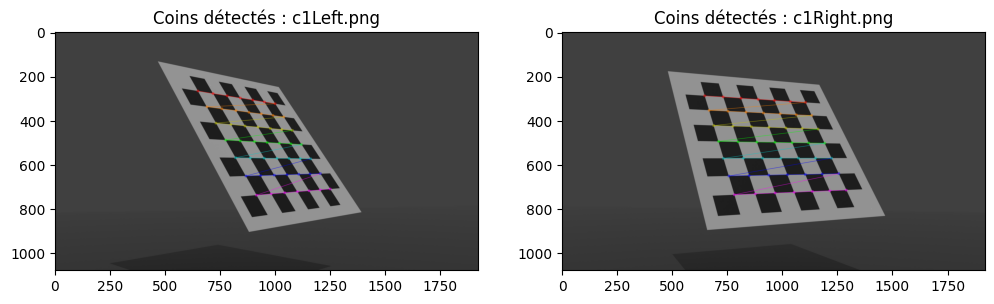

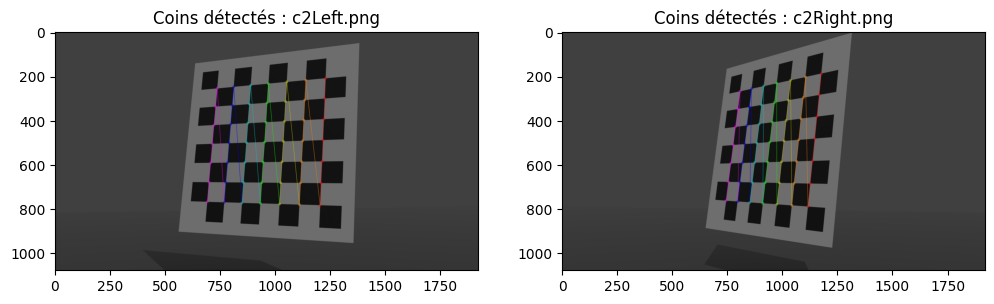

Damier NON détecté pour c3Left.png / c3Right.png


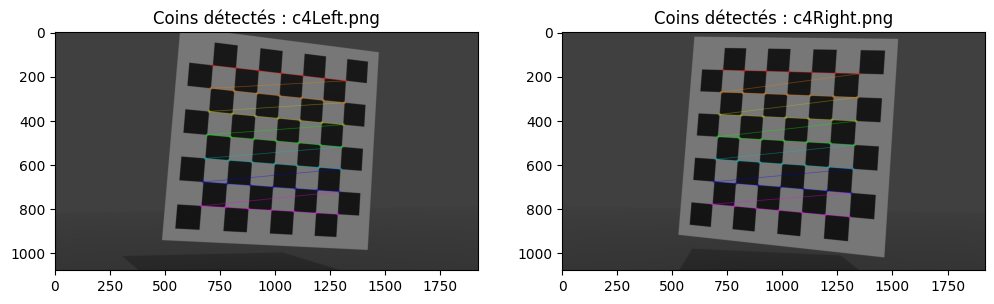

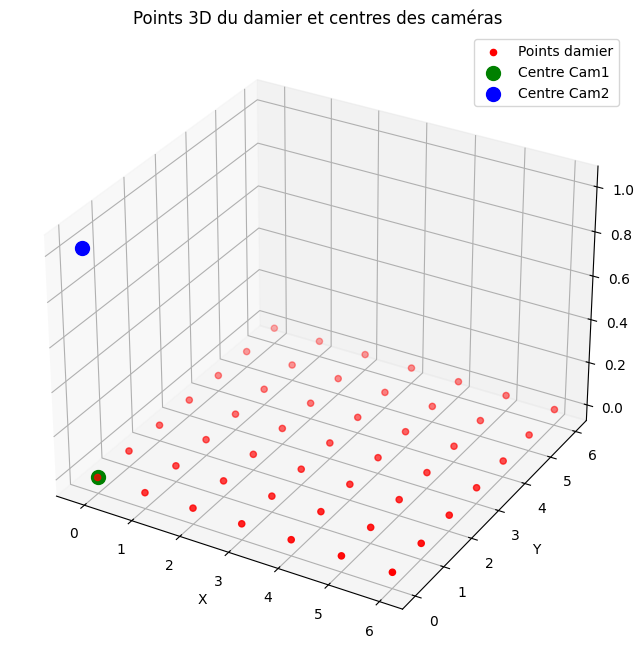

Matrices de calibration sauvegardées dans 'calibration_results.json'.


In [1]:
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import json

# --------------------------------------------------------
# 1) PARAMÈTRES ET LISTES D'IMAGES
# --------------------------------------------------------

# Damier : 7x7 intersections => 8x8 carrés
pattern_size = (7, 7)
square_size = 1.0  # Taille d’une case (ex. 1 cm)

# Prépare la grille 3D (z=0)
objp = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)
objp = objp * square_size

# Liste d'images
left_imgs = ["c1Left.png", "c2Left.png", "c3Left.png", "c4Left.png"]
right_imgs = ["c1Right.png", "c2Right.png", "c3Right.png", "c4Right.png"]

# Listes pour stockage
objpoints = []  # Liste de points 3D (toujours le même objp, mais répété)
imgpoints_left = []
imgpoints_right = []

# --------------------------------------------------------
# 2) DÉTECTION DES COINS DANS CHAQUE PAIRE
# --------------------------------------------------------

criteria_subpix = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

for fname_left, fname_right in zip(left_imgs, right_imgs):
    left_img = cv.imread(os.path.join("chessboards", fname_left))
    right_img = cv.imread(os.path.join("chessboards", fname_right))

    if left_img is None or right_img is None:
        print(f"Impossible de lire {fname_left} ou {fname_right}")
        continue

    gray_left = cv.cvtColor(left_img, cv.COLOR_BGR2GRAY)
    gray_right = cv.cvtColor(right_img, cv.COLOR_BGR2GRAY)

    found_left, corners_left = cv.findChessboardCorners(gray_left, pattern_size, None)
    found_right, corners_right = cv.findChessboardCorners(gray_right, pattern_size, None)

    if found_left and found_right:
        # Raffinage subpix
        corners_left = cv.cornerSubPix(
            gray_left, corners_left, (11, 11), (-1, -1), criteria_subpix
        )
        corners_right = cv.cornerSubPix(
            gray_right, corners_right, (11, 11), (-1, -1), criteria_subpix
        )

        # Stockage
        objpoints.append(objp)
        imgpoints_left.append(corners_left)
        imgpoints_right.append(corners_right)

        # Affichage des coins détectés
        cv.drawChessboardCorners(left_img, pattern_size, corners_left, found_left)
        cv.drawChessboardCorners(right_img, pattern_size, corners_right, found_right)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.imshow(cv.cvtColor(left_img, cv.COLOR_BGR2RGB))
        ax1.set_title(f"Coins détectés : {fname_left}")
        ax2.imshow(cv.cvtColor(right_img, cv.COLOR_BGR2RGB))
        ax2.set_title(f"Coins détectés : {fname_right}")
        plt.show()
    else:
        print(f"Damier NON détecté pour {fname_left} / {fname_right}")

if len(objpoints) < 1:
    print("Calibration impossible : pas assez de paires valides.")
    exit()

# --------------------------------------------------------
# 3) STÉRÉOCALIBRATION
# --------------------------------------------------------

cameraMatrix1 = None
distCoeffs1 = None
cameraMatrix2 = None
distCoeffs2 = None

flags_stereo = cv.CALIB_FIX_INTRINSIC
criteria_stereo = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 1e-6)

ret, cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, R, T, E, F = cv.stereoCalibrate(
    objpoints,
    imgpoints_left,
    imgpoints_right,
    cameraMatrix1,
    distCoeffs1,
    cameraMatrix2,
    distCoeffs2,
    gray_left.shape[::-1],
    criteria=criteria_stereo,
    flags=flags_stereo,
)

# --------------------------------------------------------
# 4) AFFICHAGE DES POINTS 3D ET CENTRES DES CAMÉRAS
# --------------------------------------------------------

R1 = np.eye(3, dtype=np.float64)
T1 = np.zeros((3, 1), dtype=np.float64)

# Matrices extrinsèques
extrinsic_cam1 = np.hstack((R1, T1))
extrinsic_cam2 = np.hstack((R, T))

# Centres des caméras
center_cam1 = np.array([0, 0, 0])  # Référence
center_cam2 = -R.T @ T

# Points 3D du damier (utiliser le dernier objp)
points_3D_damier = objpoints[-1]

# Visualisation en 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3D_damier[:, 0], points_3D_damier[:, 1], points_3D_damier[:, 2], c='r', label='Points damier')
ax.scatter(center_cam1[0], center_cam1[1], center_cam1[2], c='g', marker='o', s=100, label='Centre Cam1')
ax.scatter(center_cam2[0], center_cam2[1], center_cam2[2], c='b', marker='o', s=100, label='Centre Cam2')

ax.set_title("Points 3D du damier et centres des caméras")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()

# --------------------------------------------------------
# 5) SAUVEGARDE DES MATRICES
# --------------------------------------------------------

calibration_results = {
    "cameraMatrix1": cameraMatrix1.tolist(),
    "distCoeffs1": distCoeffs1.tolist(),
    "cameraMatrix2": cameraMatrix2.tolist(),
    "distCoeffs2": distCoeffs2.tolist(),
    "R": R.tolist(),
    "T": T.tolist(),
    "E": E.tolist(),
    "F": F.tolist(),
}

with open("calibration_results.json", "w") as f:
    json.dump(calibration_results, f, indent=4)

print("Matrices de calibration sauvegardées dans 'calibration_results.json'.")

Aucun point détecté dans l'image /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0000.png.


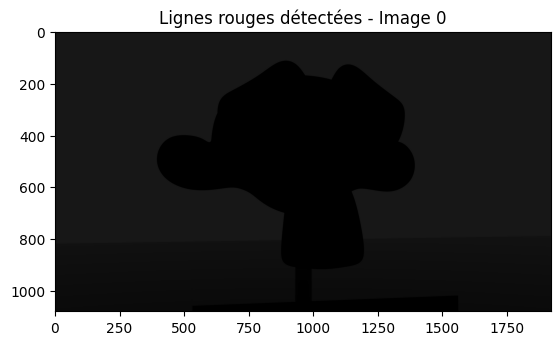

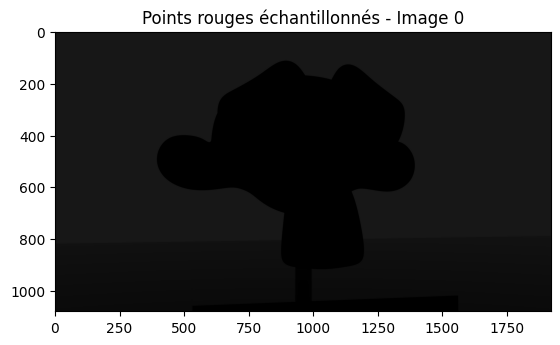

Erreur lors du calcul des épilignes pour l'image 0: Aucun point fourni pour le calcul des épilignes.
Aucun point détecté dans l'image /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0001.png.


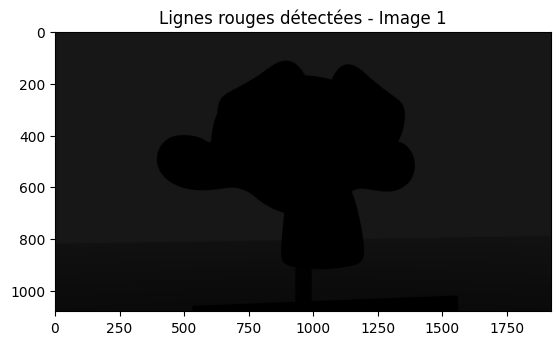

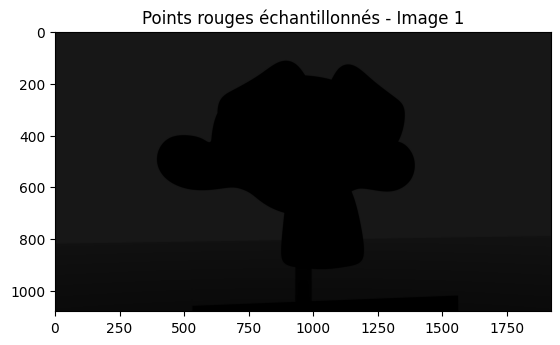

Erreur lors du calcul des épilignes pour l'image 1: Aucun point fourni pour le calcul des épilignes.
Aucun point détecté dans l'image /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0002.png.


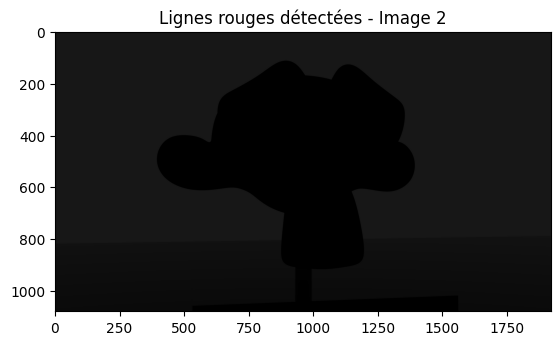

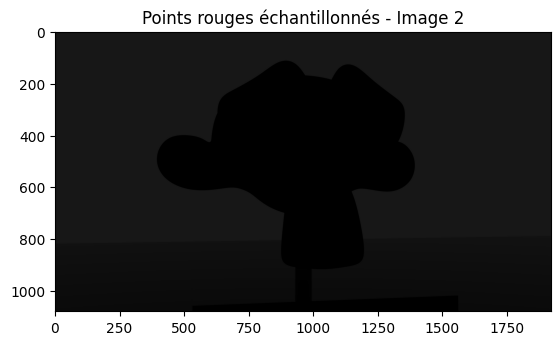

Erreur lors du calcul des épilignes pour l'image 2: Aucun point fourni pour le calcul des épilignes.


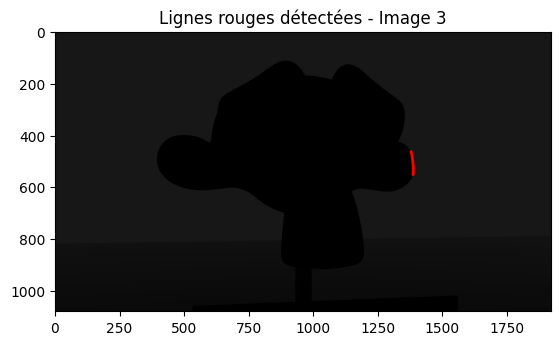

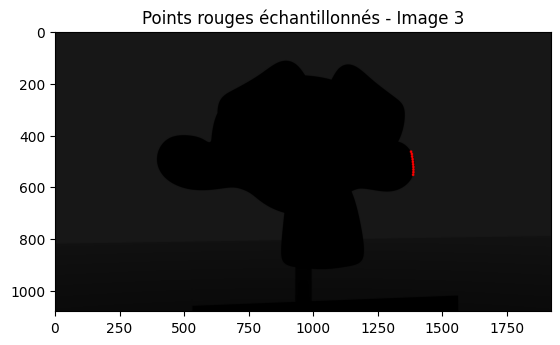

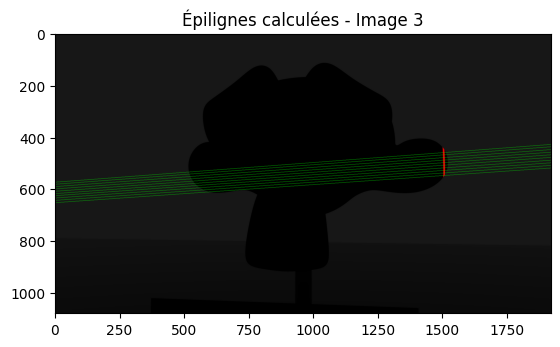

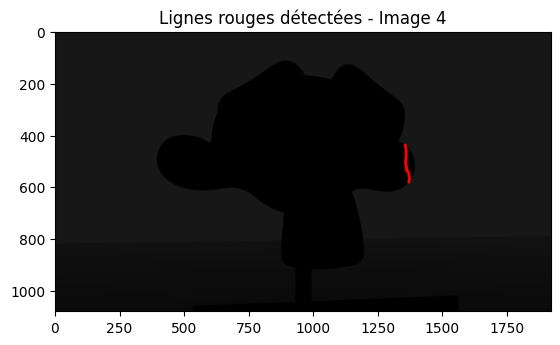

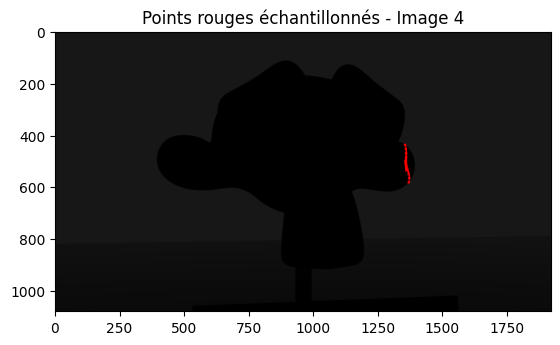

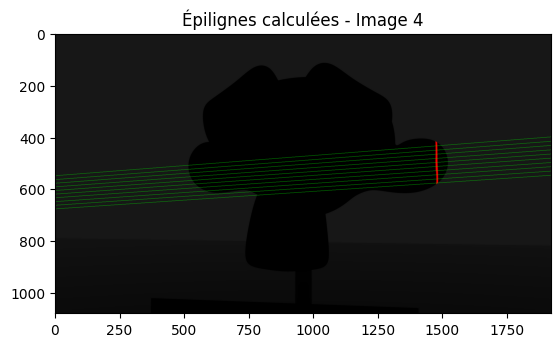

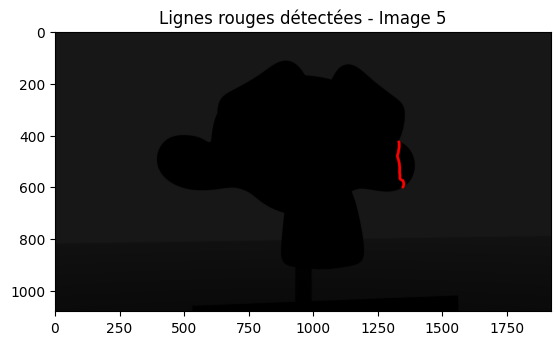

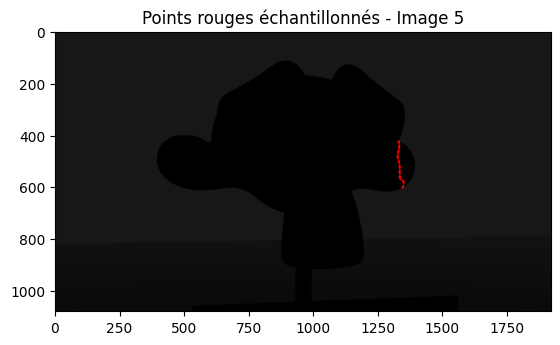

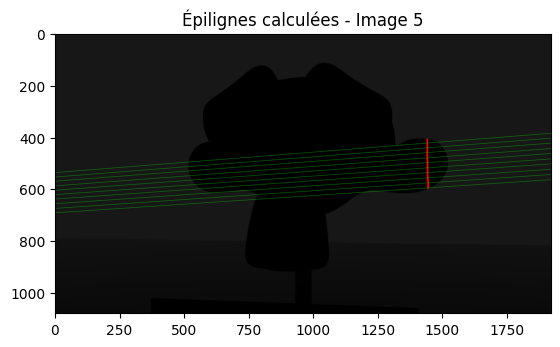

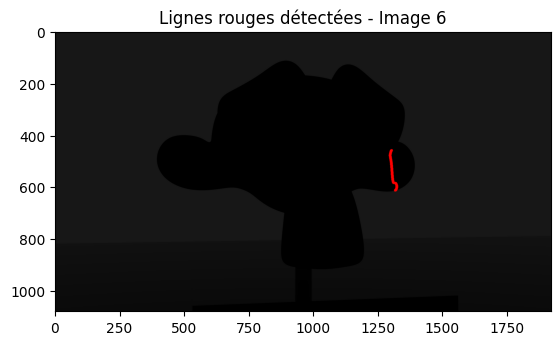

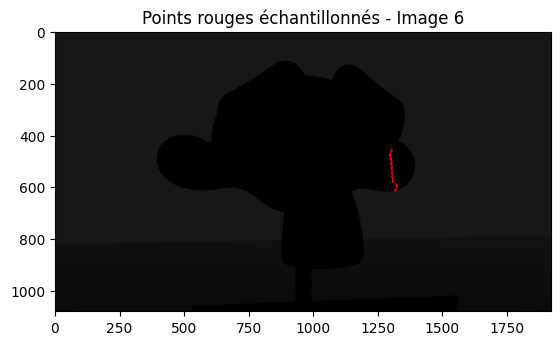

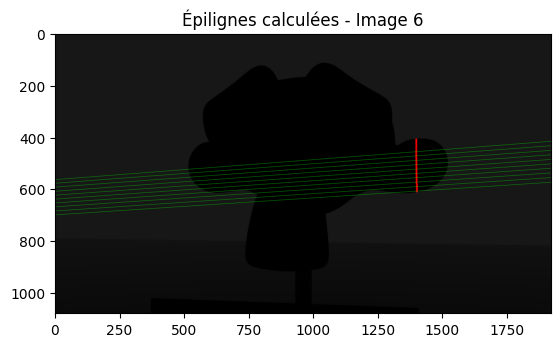

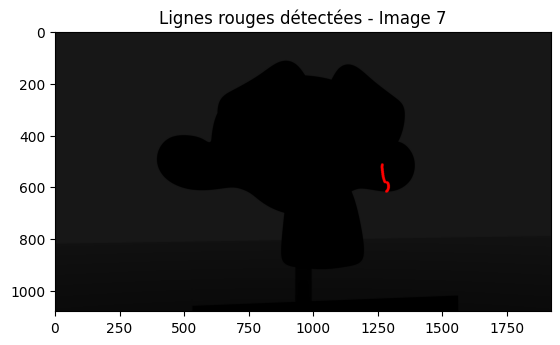

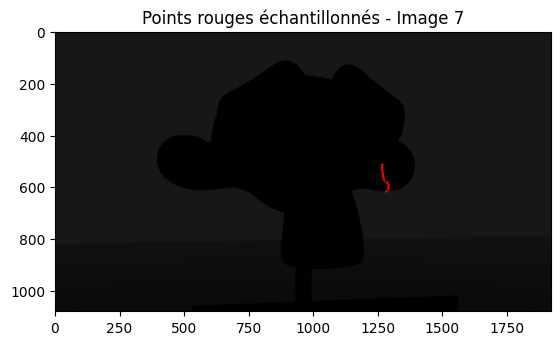

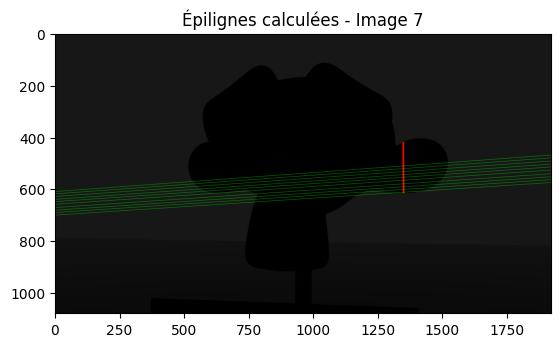

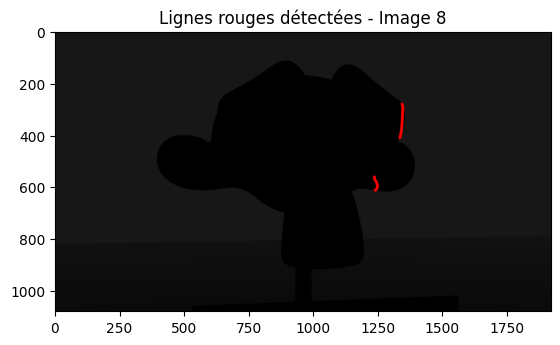

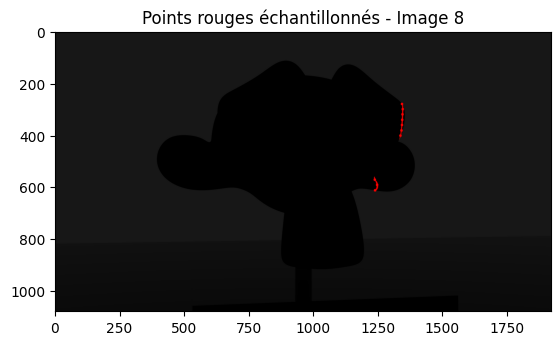

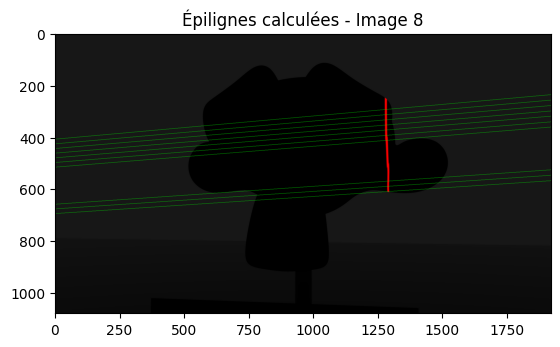

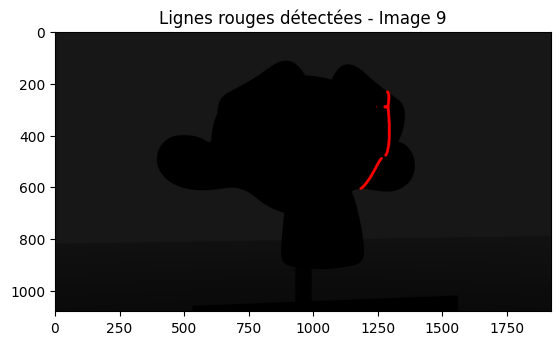

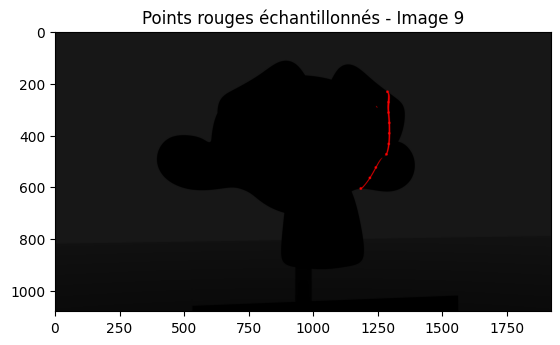

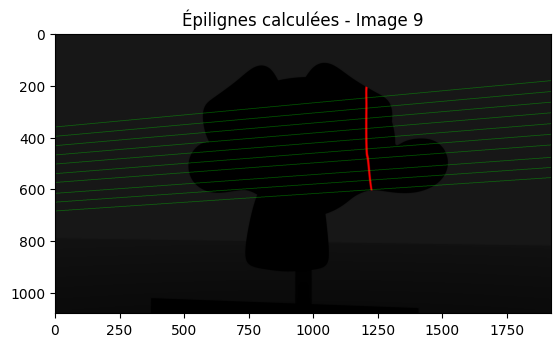

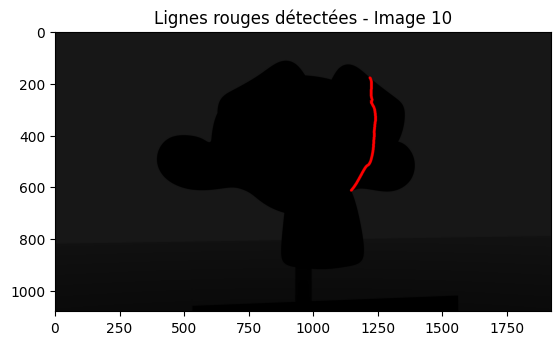

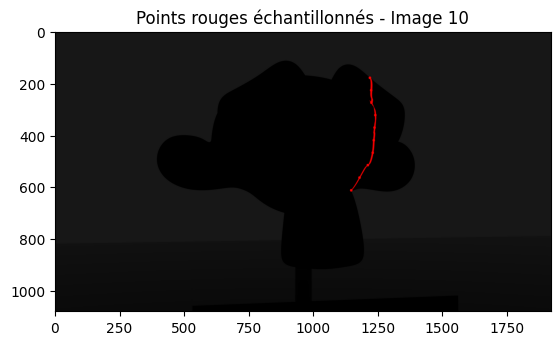

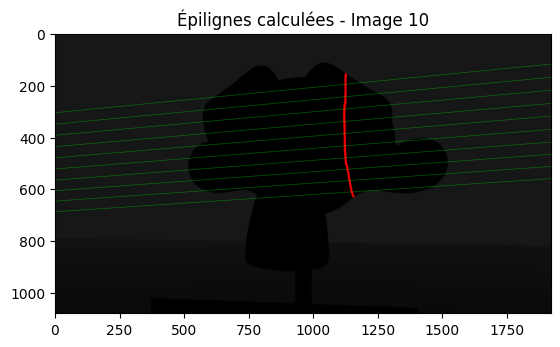

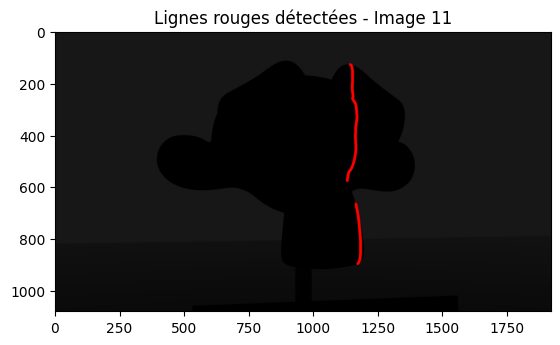

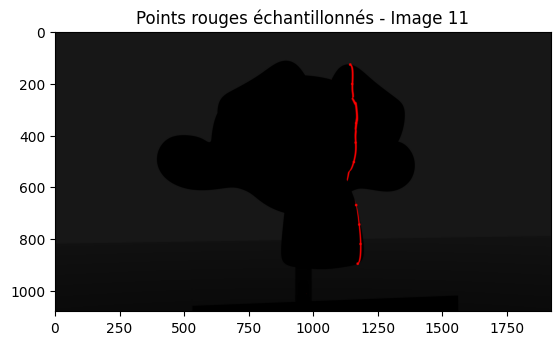

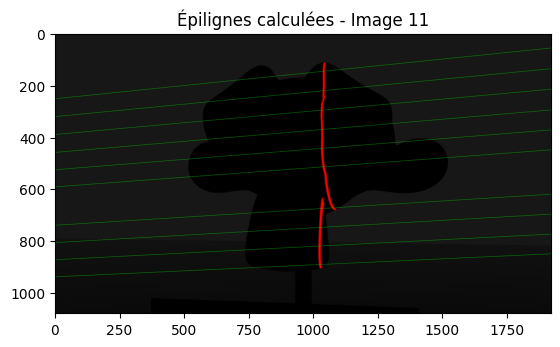

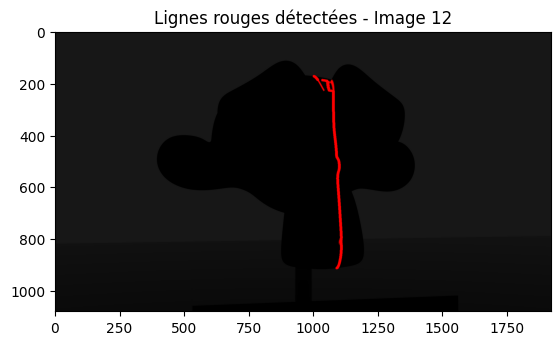

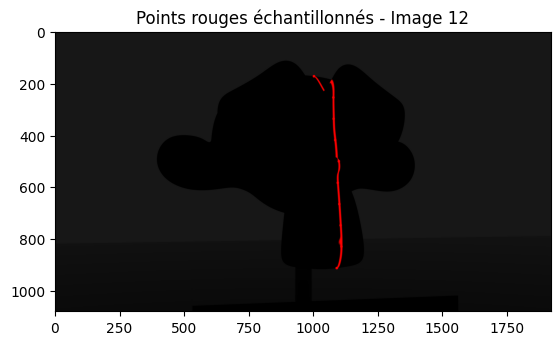

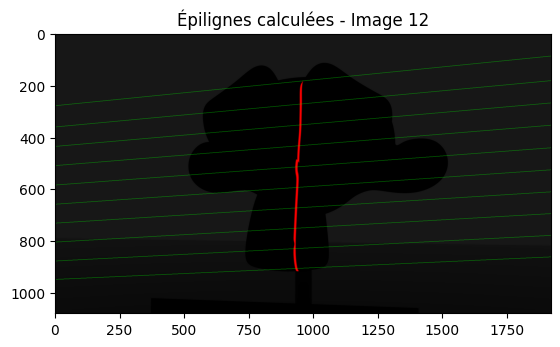

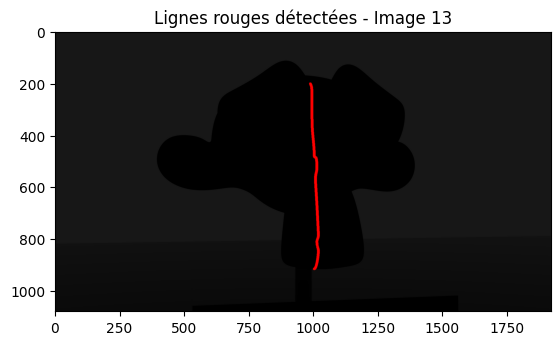

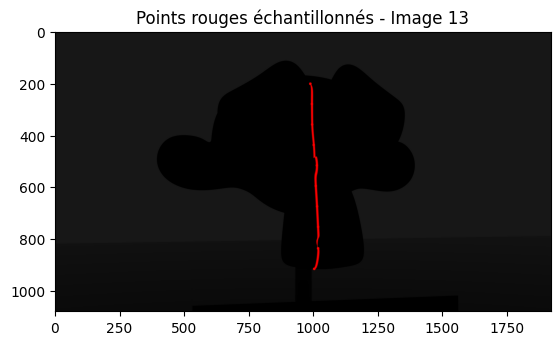

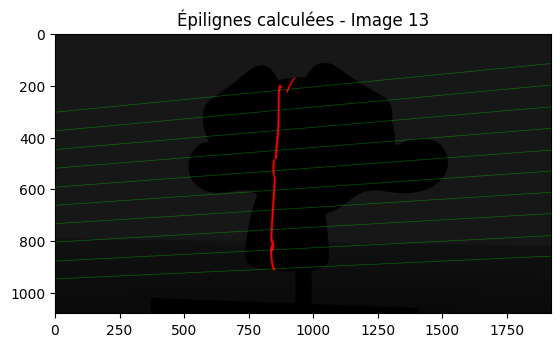

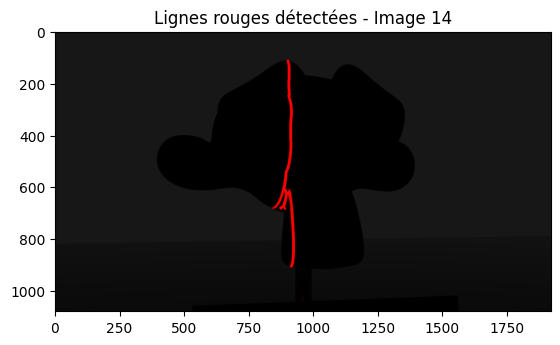

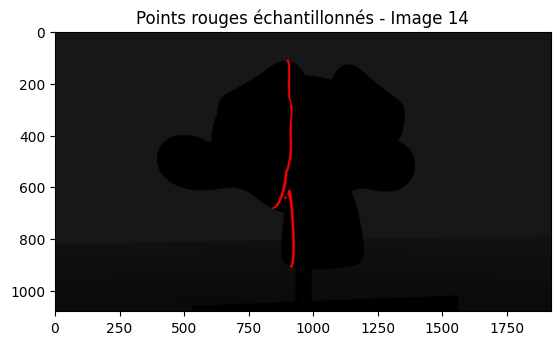

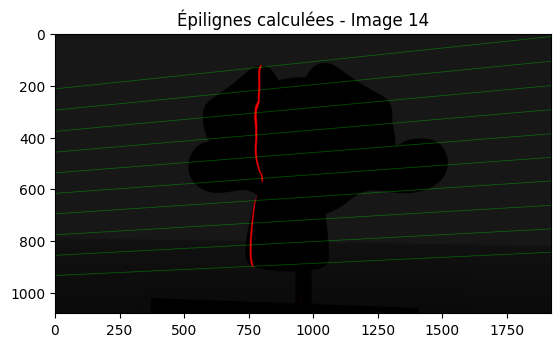

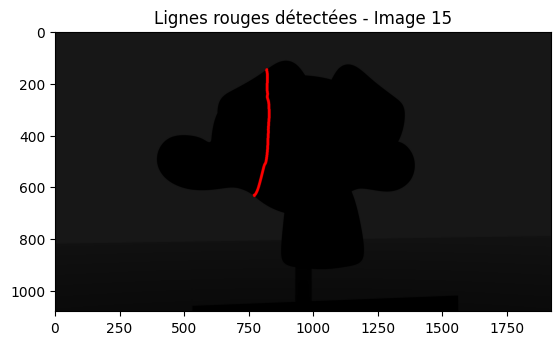

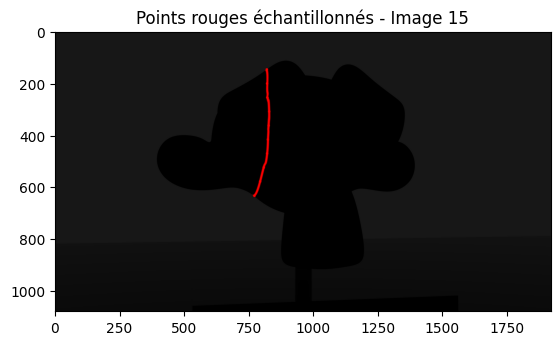

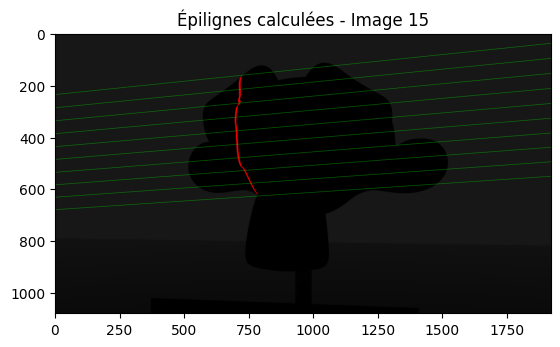

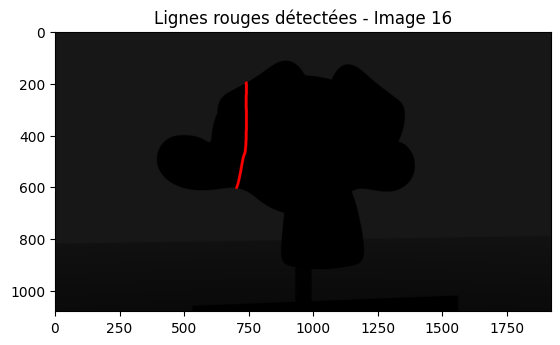

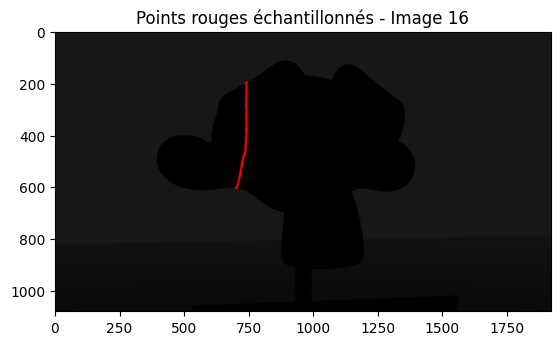

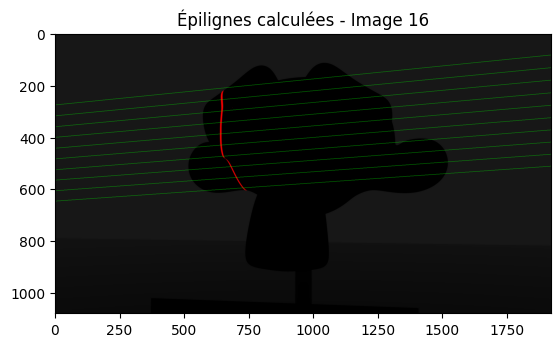

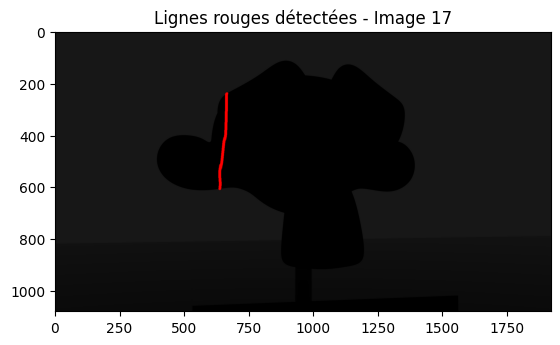

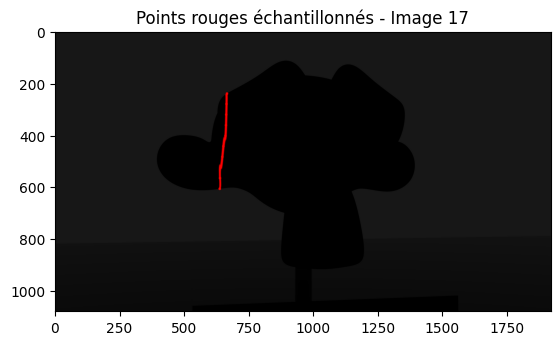

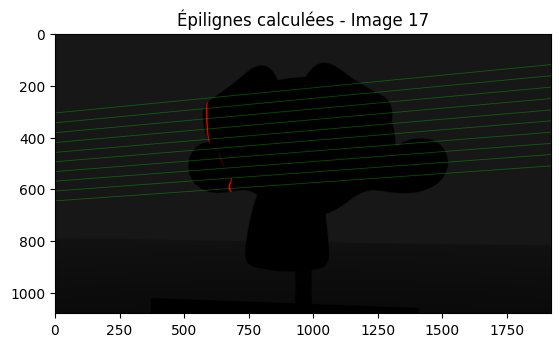

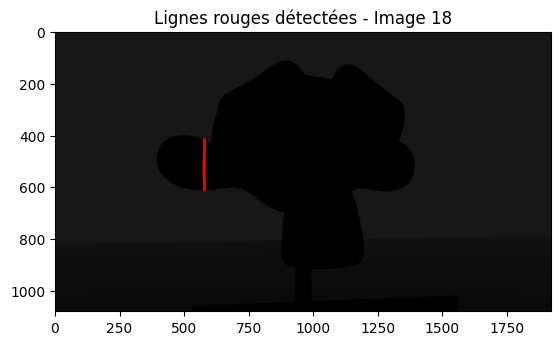

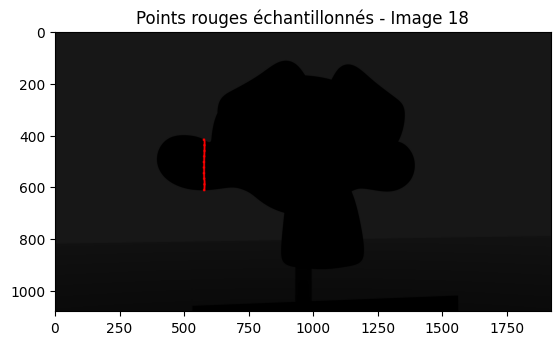

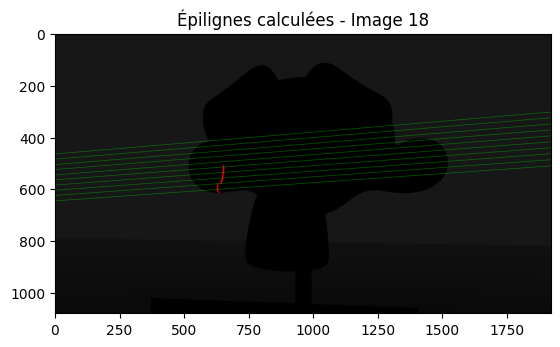

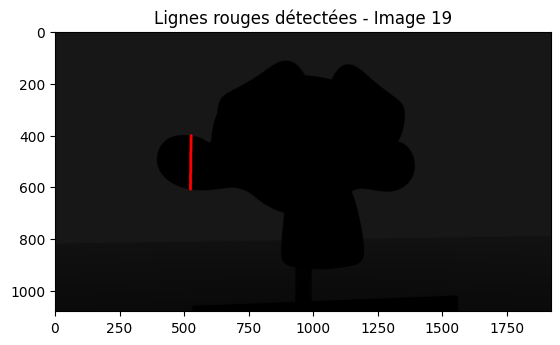

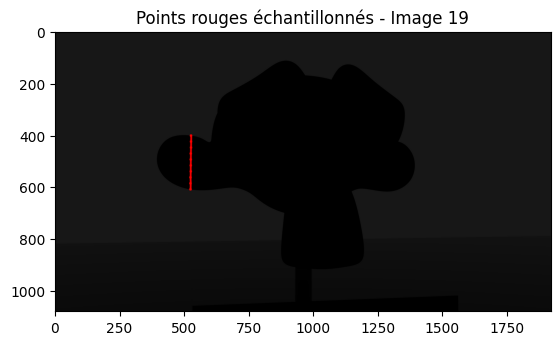

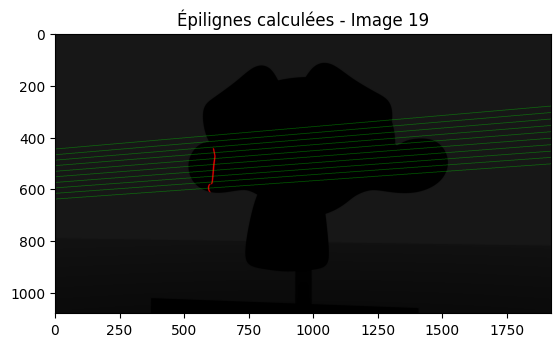

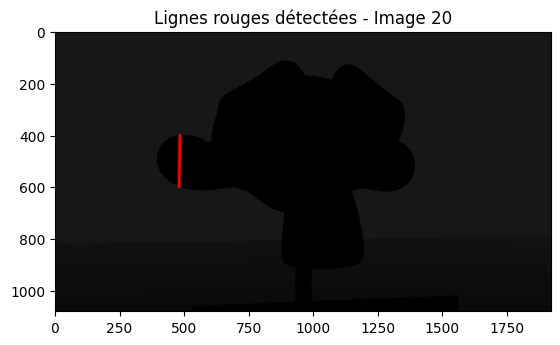

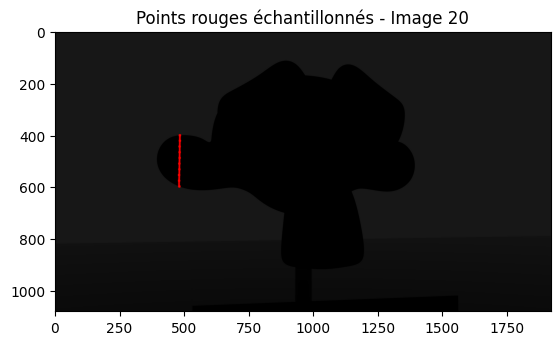

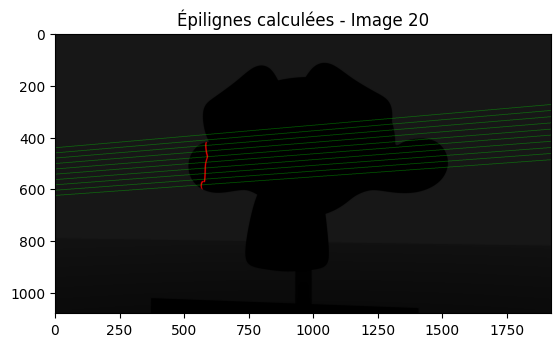

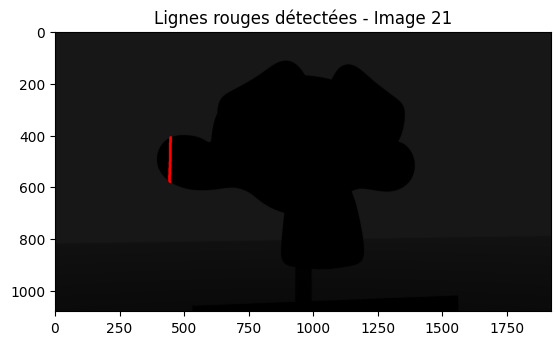

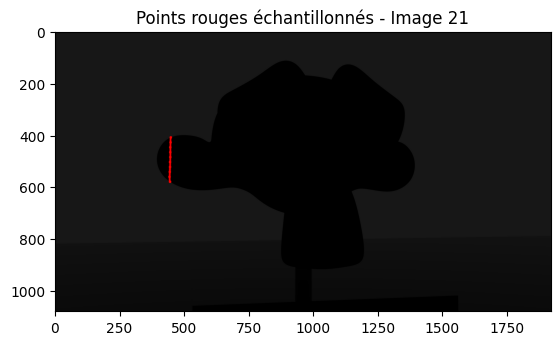

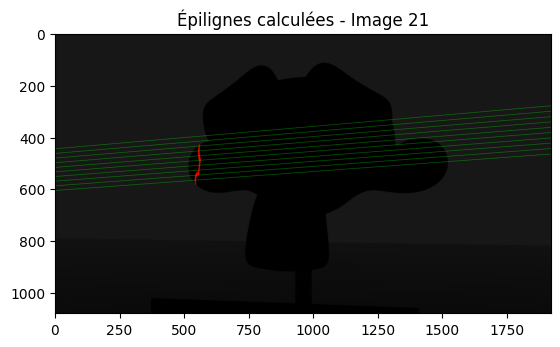

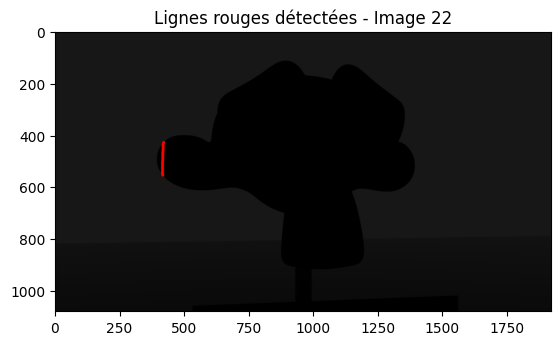

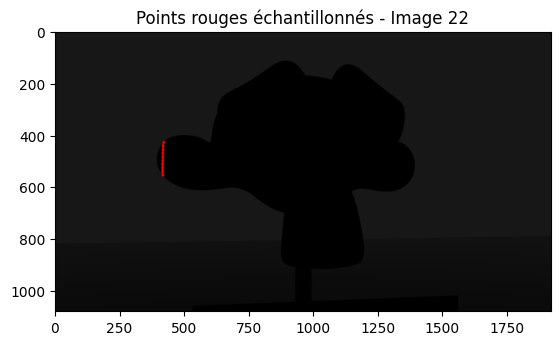

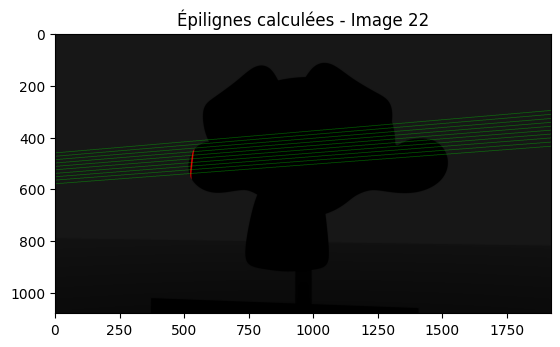

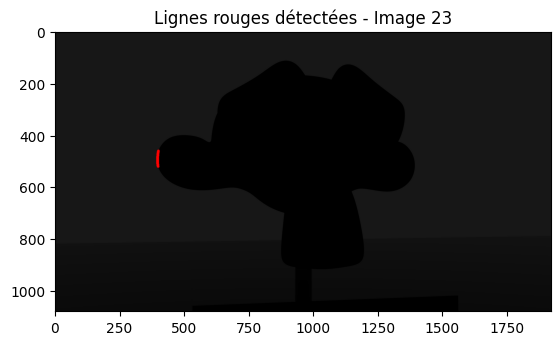

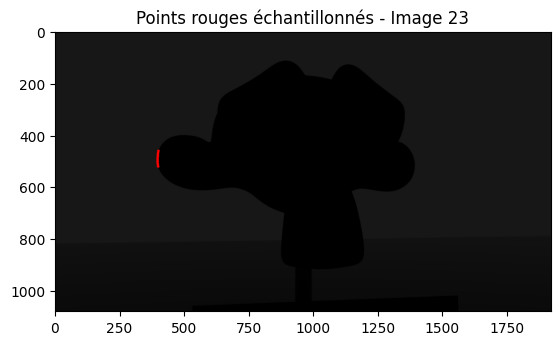

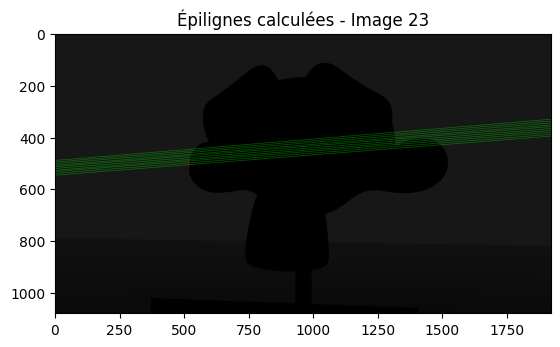

Aucun point détecté dans l'image /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0024.png.


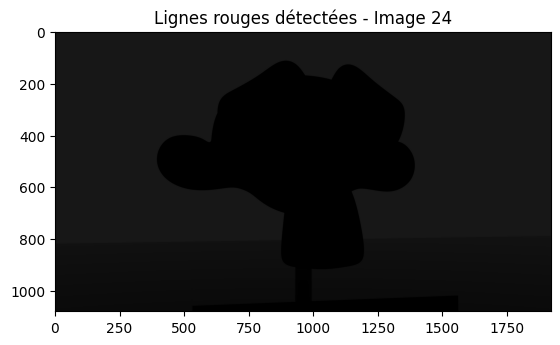

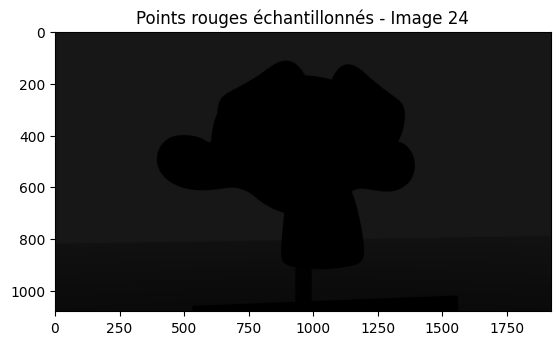

Erreur lors du calcul des épilignes pour l'image 24: Aucun point fourni pour le calcul des épilignes.
Aucun point détecté dans l'image /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0025.png.


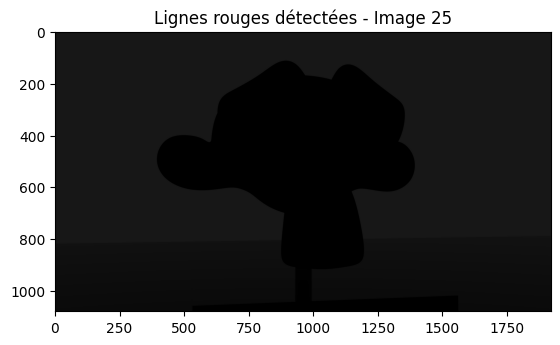

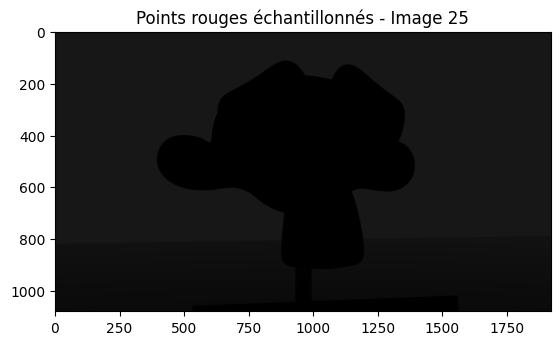

Erreur lors du calcul des épilignes pour l'image 25: Aucun point fourni pour le calcul des épilignes.
Données sauvegardées dans /Users/abdelbadi/Desktop/Traitement-Image/epl.json
Données sauvegardées dans /Users/abdelbadi/Desktop/Traitement-Image/pointsRight.json


In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import json
import os

def augmenter_luminosite(image, alpha=2.0, beta=150):
    """
    Augmente la luminosité et le contraste d'une image.
    """
    return cv.convertScaleAbs(image, alpha=alpha, beta=beta)

def detect_laser_line(image_path):
    """
    Détecte les lignes rouges (laser) dans une image.
    """
    image = cv.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Impossible de charger l'image {image_path}")

    # Extraire le canal rouge
    red_channel = image[:, :, 2]

    # Seuillage pour extraire les zones rouges
    _, mask = cv.threshold(red_channel, 200, 255, cv.THRESH_BINARY)

    # Trouver les lignes rouges comme moyenne des pixels non nuls
    points = []
    for y in range(mask.shape[0]):
        x_coords = np.where(mask[y, :] > 0)[0]
        if len(x_coords) > 0:
            x_mean = int(np.mean(x_coords))
            points.append([x_mean, y, 1])  # Coordonnées homogènes

    if not points:
        print(f"Aucun point détecté dans l'image {image_path}.")
        return np.empty((3, 0))  # Retourne une matrice vide compatible avec la multiplication

    return np.array(points).T  # Retourne un tableau (3, N)

def sample_red_lines(points, max_samples=10):
    """
    Échantillonne un sous-ensemble des points rouges détectés.
    """
    if points.shape[1] <= max_samples:
        return points  # Pas besoin d'échantillonner si le nombre de points est déjà petit.
    
    indices = np.linspace(0, points.shape[1] - 1, max_samples, dtype=int)
    sampled_points = points[:, indices]
    return sampled_points

def compute_epipolar_lines(points_left, F):
    """
    Calcule les épilignes correspondantes dans l'image droite à partir des points de l'image gauche.
    """
    if points_left.shape[1] == 0:
        raise ValueError("Aucun point fourni pour le calcul des épilignes.")
    
    epilines = F @ points_left
    return epilines

def plot_points(image_path, points, title):
    """
    Affiche les points détectés ou échantillonnés dans une image.
    """
    image = cv.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Impossible de charger l'image {image_path}")
    
    for i in range(points.shape[1]):
        x, y = int(points[0, i]), int(points[1, i])
        cv.circle(image, (x, y), 5, (0, 0, 255), -1)

    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

def plot_epilines(image_path, points, epilines, title):
    """
    Affiche les épilignes calculées dans une image.
    """
    image = cv.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Impossible de charger l'image {image_path}")
    
    h, w, _ = image.shape
    for i in range(epilines.shape[1]):
        a, b, c = epilines[:, i]
        if abs(b) < 1e-6:  # Éviter les divisions par 0
            continue
        y1 = int(-c / b)  # x=0
        y2 = int(-(c + a * (w - 1)) / b)  # x=w-1
        if 0 <= y1 < h and 0 <= y2 < h:  # Vérifier les bornes
            cv.line(image, (0, y1), (w - 1, y2), (0, 255, 0), 1)

    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

def save_to_json(data, filename):
    """
    Sauvegarde des données au format JSON.
    """
    with open(filename, "w") as f:
        json.dump(data, f)
    print(f"Données sauvegardées dans {filename}")

# Chargement des données de calibration
calibration_data = {
    "F": np.array([
        [-0.04783258005468555, -2.5494569441861787, 4053.631135532107],
        [2.4157793842037125, 1.0184203470044886, 33039.90836100082],
        [-4249.389560559821, -33015.30185077606, 1.0]
    ])
}

# Matrice fondamentale
F = calibration_data["F"]

# Exemple d'utilisation
if __name__ == "__main__":
    path_left_dir = "/Users/abdelbadi/Desktop/Traitement-Image/scanLeft/"
    path_right_dir = "/Users/abdelbadi/Desktop/Traitement-Image/scanRight/"

    n_images = 26  # Nombre d'images à traiter
    epl = []  # Liste pour stocker les points gauche et les épilignes
    points_right_list = []  # Liste pour stocker les points de droite

    for i in range(n_images):
        path_left = os.path.join(path_left_dir, f"{i:04d}.png")
        path_right = os.path.join(path_right_dir, f"scan{i:04d}.png")

        # Détecter les lignes rouges dans l'image gauche
        points_left = detect_laser_line(path_left)

        # Échantillonnage des points rouges
        sampled_points_left = sample_red_lines(points_left, max_samples=10)

        # Afficher les lignes rouges détectées
        plot_points(path_left, points_left, f"Lignes rouges détectées - Image {i}")

        # Afficher les points rouges échantillonnés
        plot_points(path_left, sampled_points_left, f"Points rouges échantillonnés - Image {i}")

        # Calcul des épilignes à partir des points échantillonnés
        try:
            epilines = compute_epipolar_lines(sampled_points_left, F)

            # Afficher les épilignes pour les points échantillonnés
            plot_epilines(path_right, sampled_points_left, epilines, f"Épilignes calculées - Image {i}")

            epl.append([sampled_points_left.tolist(), epilines.tolist()])
            points_right_list.append(sampled_points_left.tolist())
        except ValueError as e:
            print(f"Erreur lors du calcul des épilignes pour l'image {i}: {e}")
            epl.append([[], []])
            points_right_list.append([])

    # Sauvegarder epl et pointsRight
    save_to_json({"epl": epl}, "/Users/abdelbadi/Desktop/Traitement-Image/epl.json")
    save_to_json({"pointsRight": points_right_list}, "/Users/abdelbadi/Desktop/Traitement-Image/pointsRight.json")

Nombre de paires à traiter : 26
Traitement de la paire 1/26 : /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0000.png <-> /Users/abdelbadi/Desktop/Traitement-Image/scanRight/scan0000.png
Nombre de correspondances détectées : 22


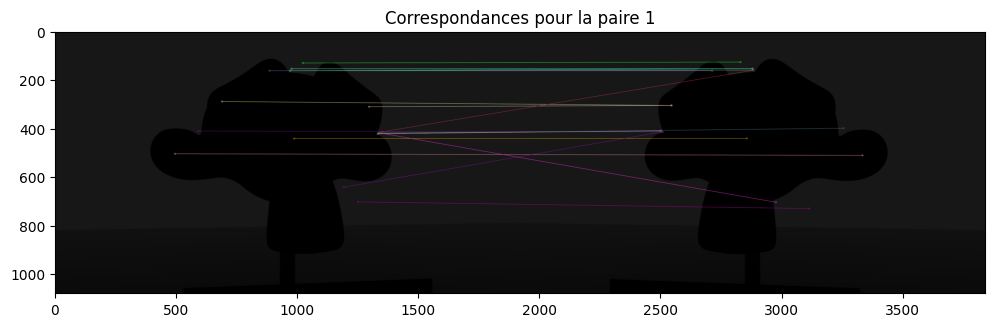

Traitement de la paire 2/26 : /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0001.png <-> /Users/abdelbadi/Desktop/Traitement-Image/scanRight/scan0001.png
Nombre de correspondances détectées : 22


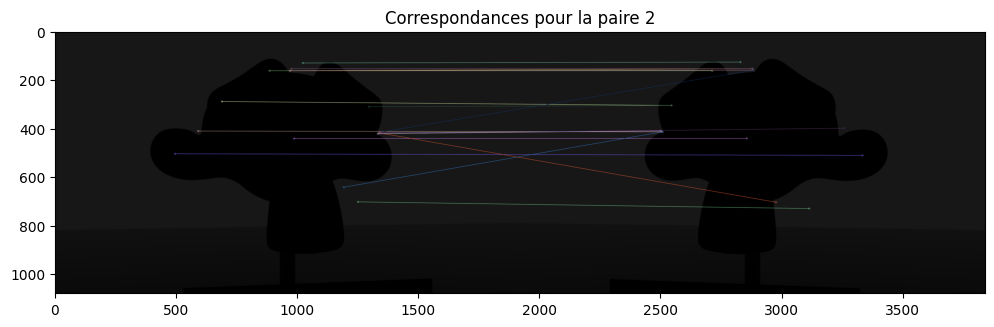

Traitement de la paire 3/26 : /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0002.png <-> /Users/abdelbadi/Desktop/Traitement-Image/scanRight/scan0002.png
Nombre de correspondances détectées : 22


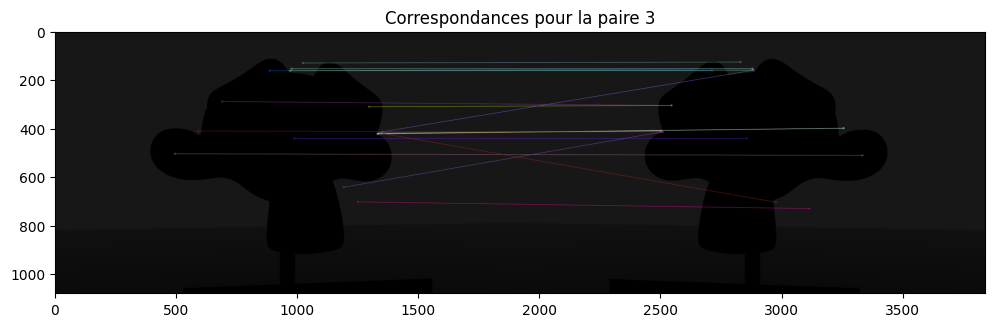

Traitement de la paire 4/26 : /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0003.png <-> /Users/abdelbadi/Desktop/Traitement-Image/scanRight/scan0003.png
Nombre de correspondances détectées : 19


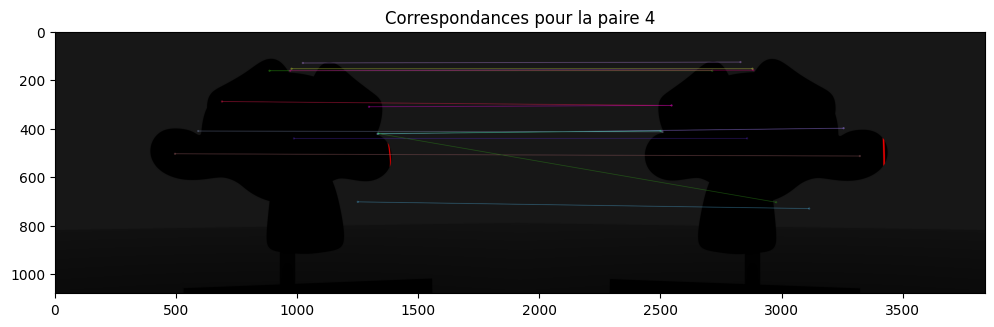

Traitement de la paire 5/26 : /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0004.png <-> /Users/abdelbadi/Desktop/Traitement-Image/scanRight/scan0004.png
Nombre de correspondances détectées : 20


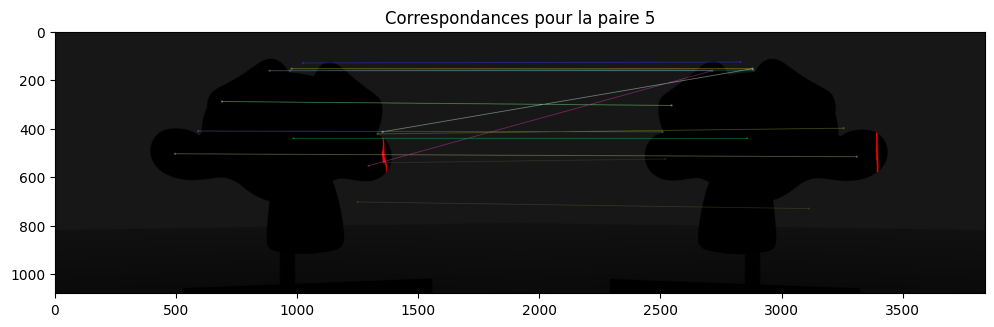

Traitement de la paire 6/26 : /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0005.png <-> /Users/abdelbadi/Desktop/Traitement-Image/scanRight/scan0005.png
Nombre de correspondances détectées : 20


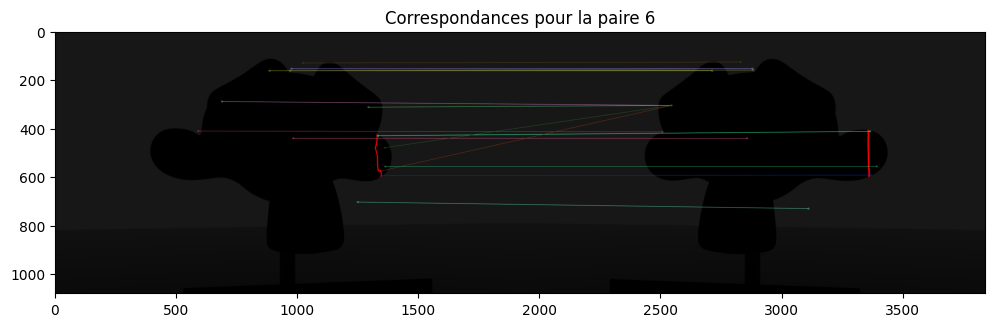

Traitement de la paire 7/26 : /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0006.png <-> /Users/abdelbadi/Desktop/Traitement-Image/scanRight/scan0006.png
Nombre de correspondances détectées : 20


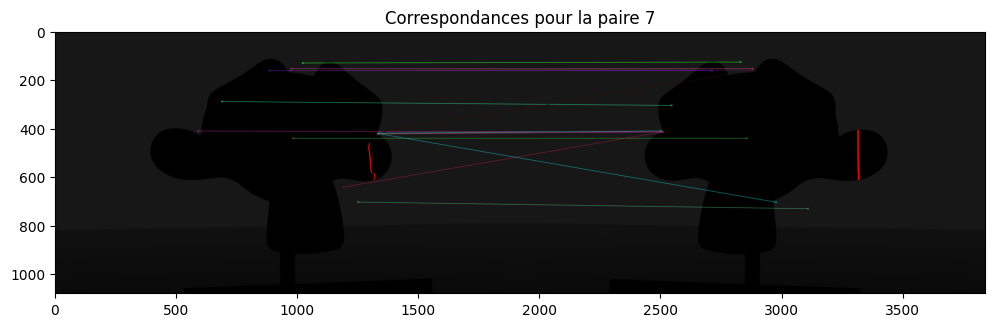

Traitement de la paire 8/26 : /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0007.png <-> /Users/abdelbadi/Desktop/Traitement-Image/scanRight/scan0007.png
Nombre de correspondances détectées : 24


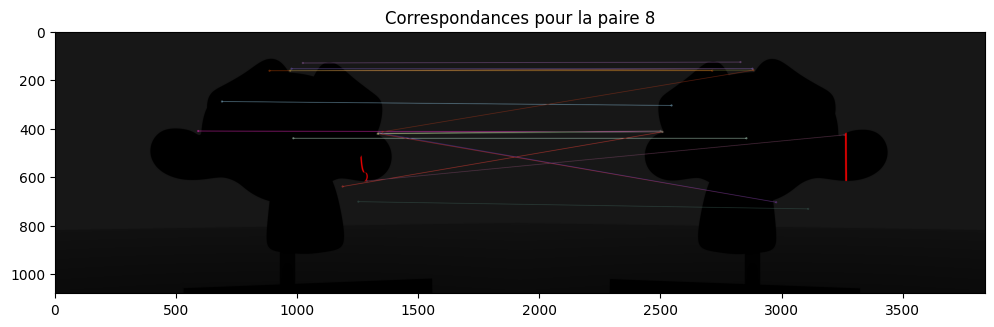

Traitement de la paire 9/26 : /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0008.png <-> /Users/abdelbadi/Desktop/Traitement-Image/scanRight/scan0008.png
Nombre de correspondances détectées : 20


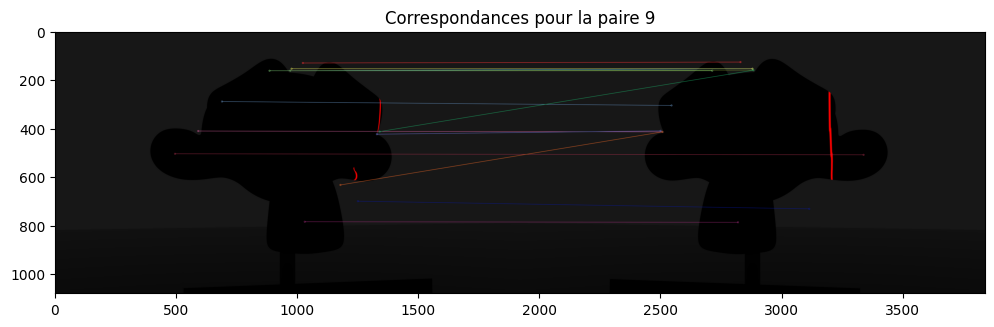

Traitement de la paire 10/26 : /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0009.png <-> /Users/abdelbadi/Desktop/Traitement-Image/scanRight/scan0009.png
Nombre de correspondances détectées : 18


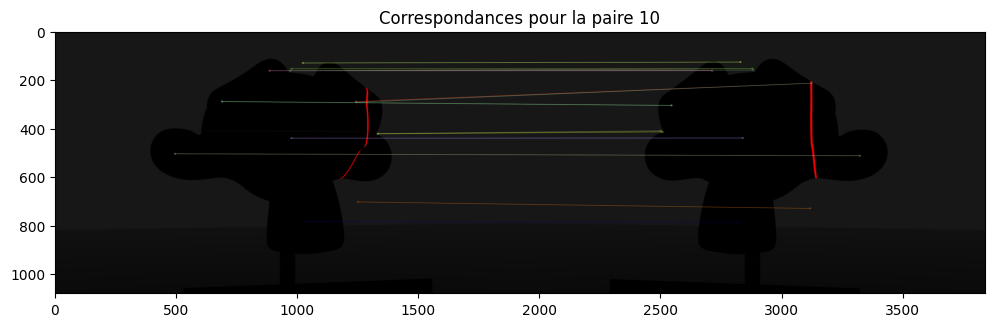

Traitement de la paire 11/26 : /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0010.png <-> /Users/abdelbadi/Desktop/Traitement-Image/scanRight/scan0010.png
Nombre de correspondances détectées : 23


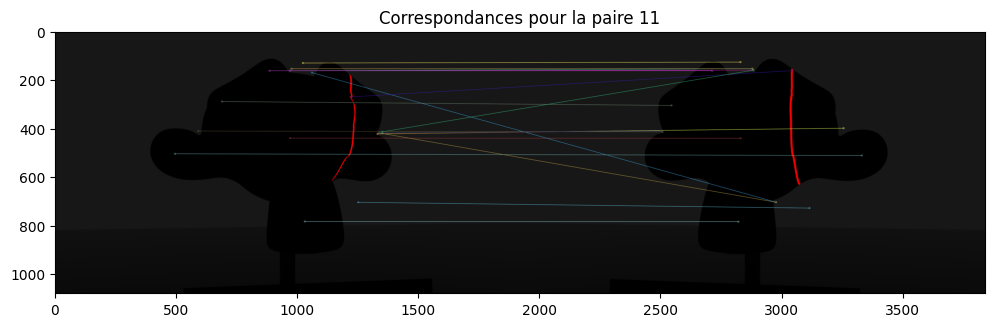

Traitement de la paire 12/26 : /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0011.png <-> /Users/abdelbadi/Desktop/Traitement-Image/scanRight/scan0011.png
Nombre de correspondances détectées : 32


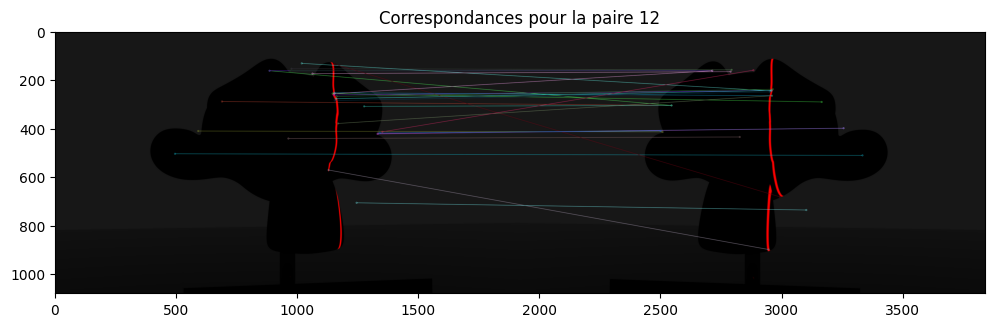

Traitement de la paire 13/26 : /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0012.png <-> /Users/abdelbadi/Desktop/Traitement-Image/scanRight/scan0012.png
Nombre de correspondances détectées : 21


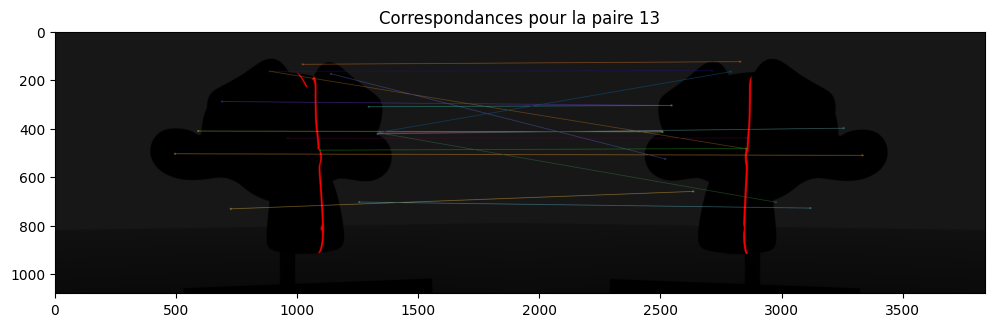

Traitement de la paire 14/26 : /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0013.png <-> /Users/abdelbadi/Desktop/Traitement-Image/scanRight/scan0013.png
Nombre de correspondances détectées : 25


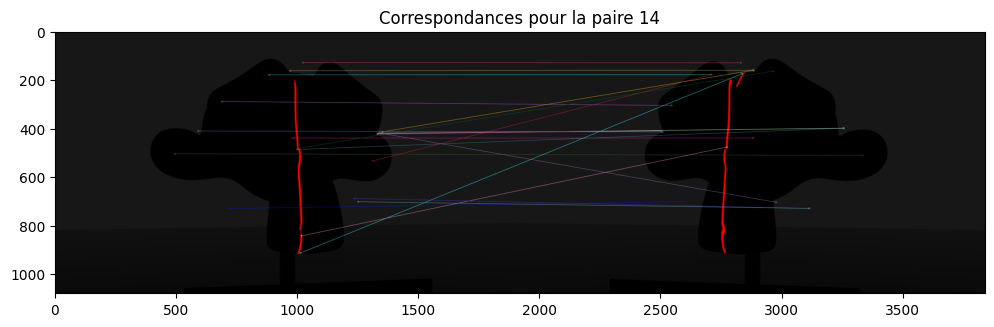

Traitement de la paire 15/26 : /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0014.png <-> /Users/abdelbadi/Desktop/Traitement-Image/scanRight/scan0014.png
Nombre de correspondances détectées : 22


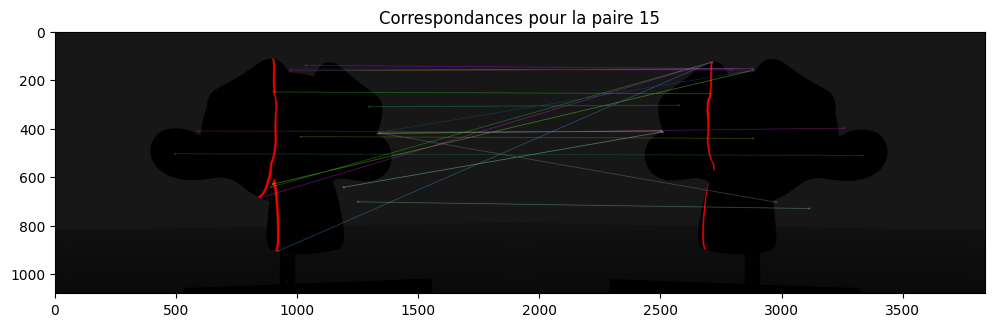

Traitement de la paire 16/26 : /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0015.png <-> /Users/abdelbadi/Desktop/Traitement-Image/scanRight/scan0015.png
Nombre de correspondances détectées : 22


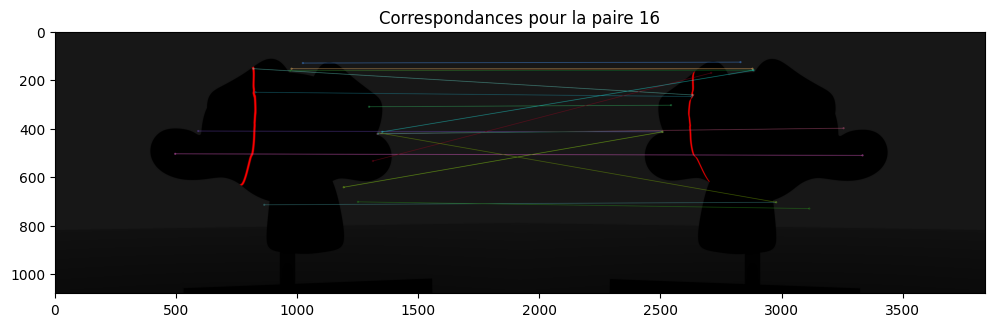

Traitement de la paire 17/26 : /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0016.png <-> /Users/abdelbadi/Desktop/Traitement-Image/scanRight/scan0016.png
Nombre de correspondances détectées : 17


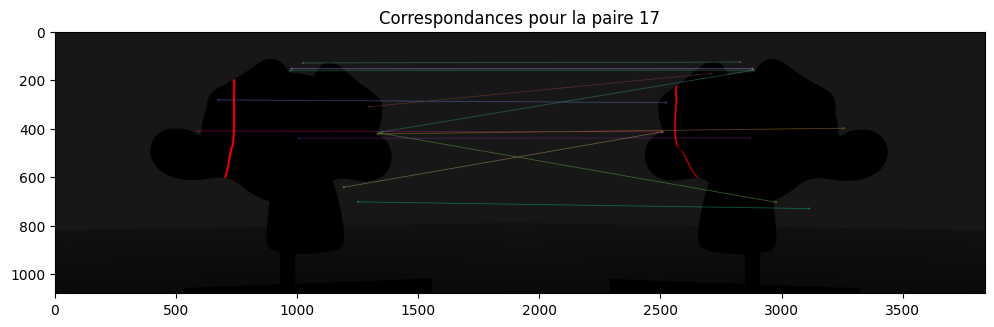

Traitement de la paire 18/26 : /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0017.png <-> /Users/abdelbadi/Desktop/Traitement-Image/scanRight/scan0017.png
Nombre de correspondances détectées : 17


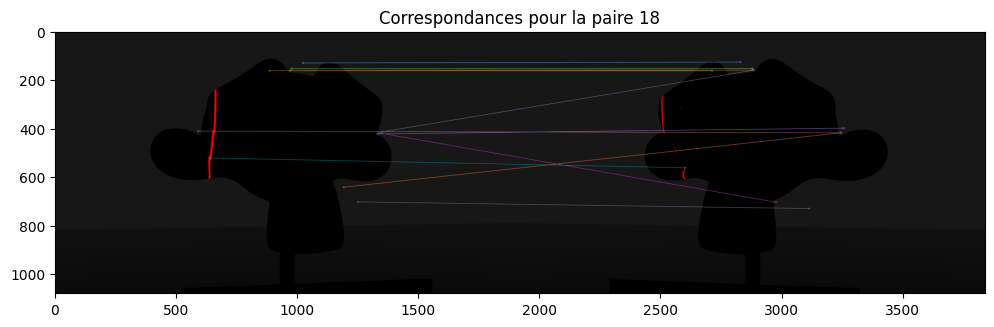

Traitement de la paire 19/26 : /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0018.png <-> /Users/abdelbadi/Desktop/Traitement-Image/scanRight/scan0018.png
Nombre de correspondances détectées : 25


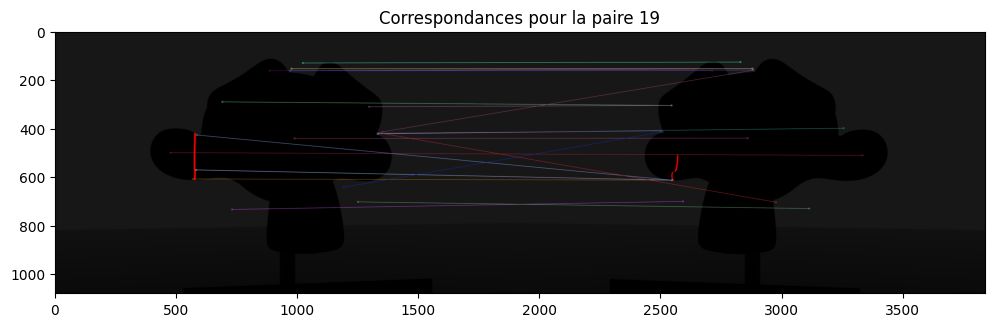

Traitement de la paire 20/26 : /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0019.png <-> /Users/abdelbadi/Desktop/Traitement-Image/scanRight/scan0019.png
Nombre de correspondances détectées : 23


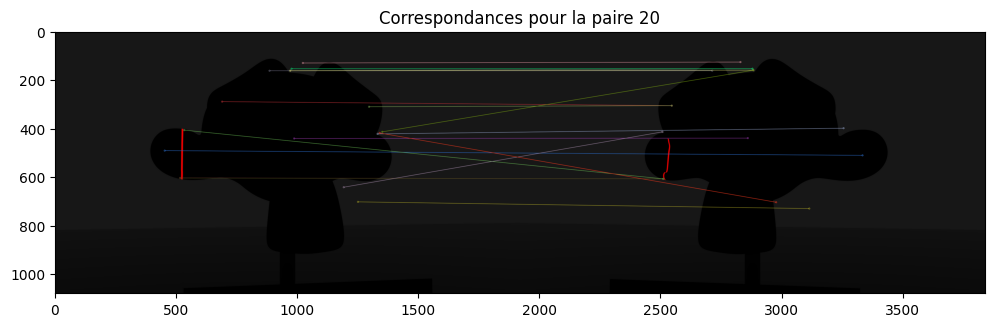

Traitement de la paire 21/26 : /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0020.png <-> /Users/abdelbadi/Desktop/Traitement-Image/scanRight/scan0020.png
Nombre de correspondances détectées : 24


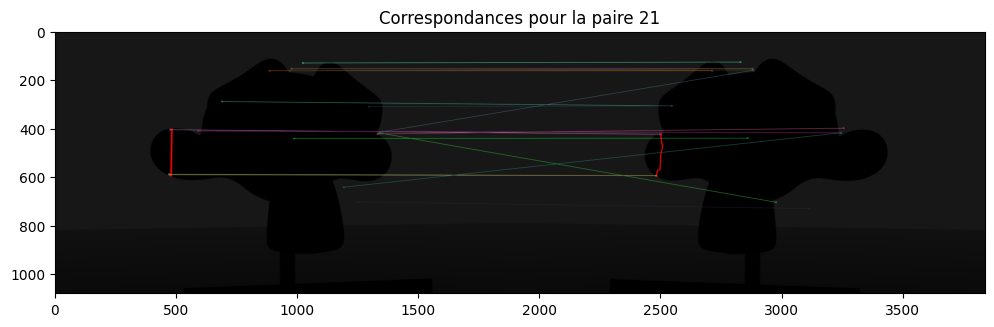

Traitement de la paire 22/26 : /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0021.png <-> /Users/abdelbadi/Desktop/Traitement-Image/scanRight/scan0021.png
Nombre de correspondances détectées : 23


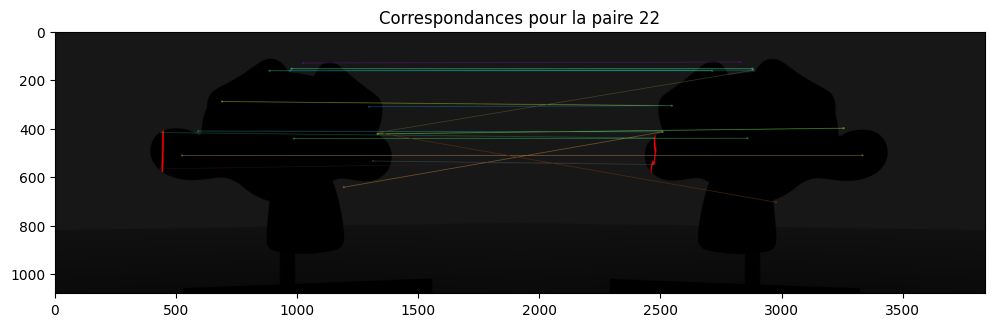

Traitement de la paire 23/26 : /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0022.png <-> /Users/abdelbadi/Desktop/Traitement-Image/scanRight/scan0022.png
Nombre de correspondances détectées : 20


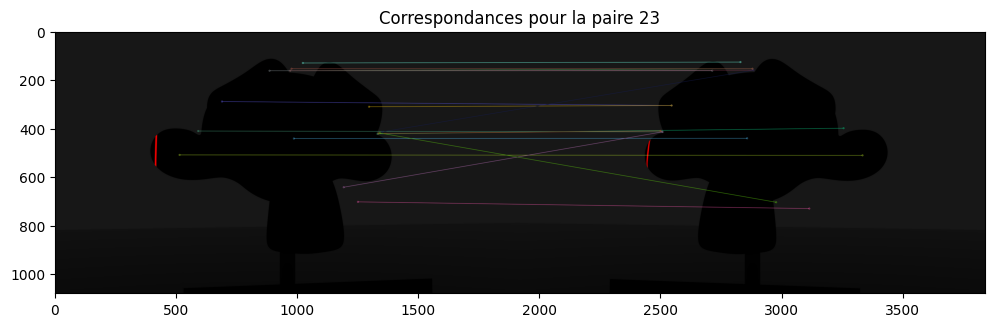

Traitement de la paire 24/26 : /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0023.png <-> /Users/abdelbadi/Desktop/Traitement-Image/scanRight/scan0023.png
Nombre de correspondances détectées : 22


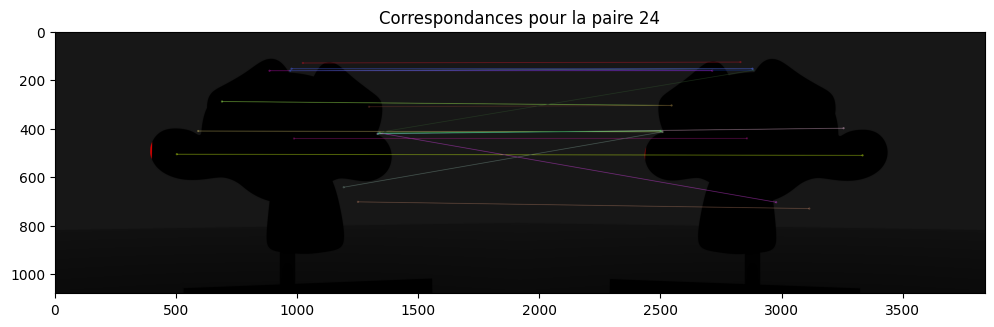

Traitement de la paire 25/26 : /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0024.png <-> /Users/abdelbadi/Desktop/Traitement-Image/scanRight/scan0024.png
Nombre de correspondances détectées : 22


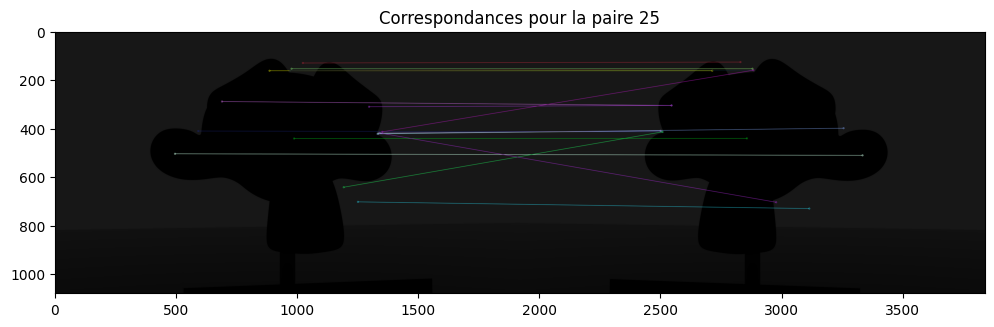

Traitement de la paire 26/26 : /Users/abdelbadi/Desktop/Traitement-Image/scanLeft/0025.png <-> /Users/abdelbadi/Desktop/Traitement-Image/scanRight/scan0025.png
Nombre de correspondances détectées : 22


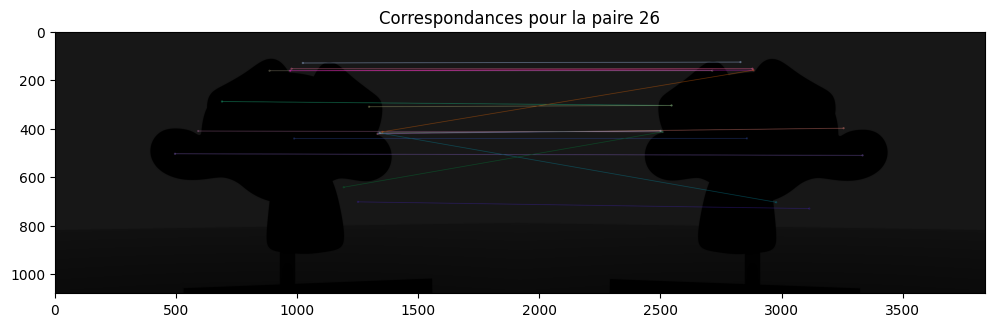

Traitement terminé.


In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import glob

def augmenter_luminosite(image, alpha=2.0, beta=150):
    """
    Augmente fortement la luminosité et le contraste d'une image.
    alpha: facteur de contraste (>1 pour augmenter)
    beta: facteur de luminosité (valeurs positives pour augmenter)
    """
    return cv.convertScaleAbs(image, alpha=alpha, beta=beta)

def sift_stereo_onepair(img_left_path, img_right_path, ratio_thresh=0.85):
    img_left = cv.imread(img_left_path, cv.IMREAD_GRAYSCALE)
    img_right = cv.imread(img_right_path, cv.IMREAD_GRAYSCALE)
    if img_left is None or img_right is None:
        print(f"Impossible de lire {img_left_path} ou {img_right_path}")
        return None, None, [], None, None

    # Augmenter davantage la luminosité
    img_left = augmenter_luminosite(img_left, alpha=2.0, beta=150)
    img_right = augmenter_luminosite(img_right, alpha=2.0, beta=150)

    # Création du détecteur SIFT
    sift = cv.SIFT_create()
    kp_left, des_left = sift.detectAndCompute(img_left, None)
    kp_right, des_right = sift.detectAndCompute(img_right, None)

    if des_left is None or des_right is None:
        print("Erreur : Impossible de détecter des descripteurs SIFT.")
        return None, None, [], None, None

    # BFMatcher avec ratio test
    bf = cv.BFMatcher()
    matches_k2 = bf.knnMatch(des_left, des_right, k=2)

    good_matches = []
    for m, n in matches_k2:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)

    pts_left = np.array([kp_left[m.queryIdx].pt for m in good_matches], dtype=np.float32)
    pts_right = np.array([kp_right[m.trainIdx].pt for m in good_matches], dtype=np.float32)

    return pts_left, pts_right, good_matches, kp_left, kp_right

if __name__ == "__main__":
    pathLeft = r"/Users/abdelbadi/Desktop/Traitement-Image/scanLeft"
    pathRight = r"/Users/abdelbadi/Desktop/Traitement-Image/scanRight"

    left_files = sorted(glob.glob(f"{pathLeft}/*.png"))
    right_files = sorted(glob.glob(f"{pathRight}/*.png"))

    nb_pairs = min(len(left_files), len(right_files))
    print(f"Nombre de paires à traiter : {nb_pairs}")

    for i in range(nb_pairs):
        left_img = left_files[i]
        right_img = right_files[i]
        print(f"Traitement de la paire {i+1}/{nb_pairs} : {left_img} <-> {right_img}")

        pts_left, pts_right, good_matches, kp_left, kp_right = sift_stereo_onepair(left_img, right_img)

        if pts_left is None or pts_right is None or len(good_matches) == 0:
            print(f"Erreur ou pas de correspondances détectées pour la paire {i+1}.")
            continue

        print(f"Nombre de correspondances détectées : {len(good_matches)}")

        # Visualisation des correspondances
        img_left = cv.imread(left_img)
        img_right = cv.imread(right_img)
        matched_img = cv.drawMatches(img_left, kp_left, img_right, kp_right, good_matches, None,
                                     flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.figure(figsize=(12, 6))
        plt.title(f"Correspondances pour la paire {i+1}")
        plt.imshow(cv.cvtColor(matched_img, cv.COLOR_BGR2RGB))
        plt.show()

    print("Traitement terminé.")

[Info] Ignorer l'image 0 (aucun point détecté).
[Info] Ignorer l'image 1 (aucun point détecté).
[Info] Ignorer l'image 2 (aucun point détecté).
[Info] Ignorer l'image 24 (aucun point détecté).
[Info] Ignorer l'image 25 (aucun point détecté).


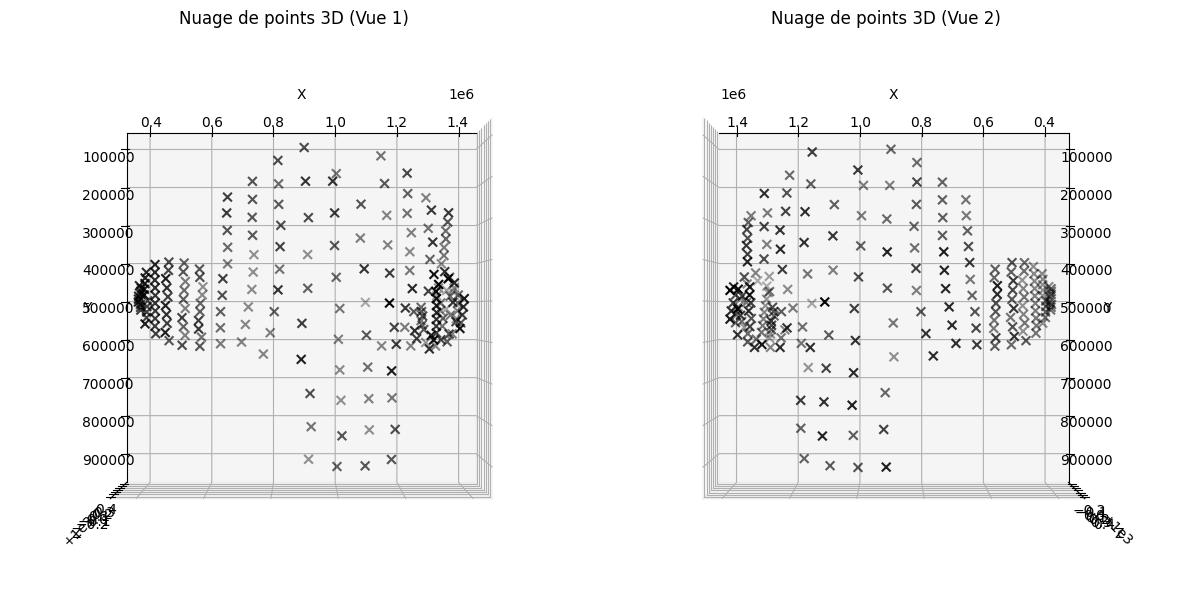

Points 3D sauvegardés dans /Users/abdelbadi/Desktop/Traitement-Image/point3D.json


In [29]:
import numpy as np
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mathutils import geometry as pygeo
from mathutils import Vector

# ----------------------------------------------------------------------------
# Fonctions utilitaires
# ----------------------------------------------------------------------------

def arrayToVector(p):
    """
    Convertit un array NumPy p = [x,y,z] en Vector mathutils
    """
    return Vector((p[0], p[1], p[2]))

# ----------------------------------------------------------------------------
# getIntersection
# ----------------------------------------------------------------------------
def getIntersection(pointLeft, pointRight, camLeft, camRight, camWorldCenterLeft, camWorldCenterRight):
    """
    Calcule le point d'intersection (en 3D) des lignes provenant de deux caméras.
    """
    pL = np.array(pointLeft)
    pR = np.array(pointRight)

    leftObject = np.linalg.pinv(camLeft) @ pL
    rightObject = np.linalg.pinv(camRight) @ pR

    leftEndVec = arrayToVector(leftObject[:3])
    rightEndVec = arrayToVector(rightObject[:3])

    leftStartVec = arrayToVector(camWorldCenterLeft)
    rightStartVec = arrayToVector(camWorldCenterRight)

    return pygeo.intersect_line_line(leftStartVec, leftEndVec, rightStartVec, rightEndVec)

# ----------------------------------------------------------------------------
# getObjectPoint
# ----------------------------------------------------------------------------
def getObjectPoint(epl, pointsRight, camLeft, camRight, camWorldCenterLeft, camWorldCenterRight, scale=1000.0, nImages=26):
    """
    Calcule les points 3D en triangulant les correspondances gauche-droite.
    """
    point = [[], [], []]  # Pour les coordonnées x, y, z

    for l in range(nImages):
        if l >= len(epl) or l >= len(pointsRight):
            print(f"[Info] Ignorer l'image {l} (données manquantes).")
            continue

        pointsLeft = np.array(epl[l][0]) if epl[l][0] else np.empty((3, 0))
        ptsRight = np.array(pointsRight[l]) if pointsRight[l] else np.empty((3, 0))

        if pointsLeft.shape[1] == 0 or ptsRight.shape[1] == 0:
            print(f"[Info] Ignorer l'image {l} (aucun point détecté).")
            continue

        nb_cols = min(pointsLeft.shape[1], ptsRight.shape[1])

        for i in range(nb_cols):
            try:
                inter = getIntersection(pointsLeft[:, i], ptsRight[:, i], camLeft, camRight, camWorldCenterLeft, camWorldCenterRight)
                if inter is not None:
                    pA, pB = inter
                    p = (pA + pB) / 2.0
                    x, y, z = p.x * scale, p.y * scale, p.z * scale
                    point[0].append(x)
                    point[1].append(y)
                    point[2].append(z)
            except Exception as e:
                print(f"Erreur d'intersection pour l'image {l}, point {i}: {e}")
                continue

    return np.array(point)

# ----------------------------------------------------------------------------
# Visualisation des points
# ----------------------------------------------------------------------------
def drawPointObject(point3D):
    """
    Affiche un nuage de points 3D.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(point3D[0, :], point3D[1, :], point3D[2, :], s=40, c='black', marker='x')
    ax.view_init(elev=-90, azim=-70)
    plt.title("Nuage de points 3D")
    plt.show()

def pointToJson(point3D, outname="point3D.json"):
    """
    Sauvegarde le nuage de points 3D dans un fichier JSON.
    """
    data = {
        "x": point3D[0, :].tolist(),
        "y": point3D[1, :].tolist(),
        "z": point3D[2, :].tolist()
    }
    with open(outname, "w") as f:
        json.dump(data, f)
    print(f"Points 3D sauvegardés dans {outname}")

def drawPointObjectWithViews(point3D):
    """
    Affiche un nuage de points 3D sous deux angles différents.
    """
    fig = plt.figure(figsize=(12, 6))

    # Vue 1
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter3D(point3D[0, :], point3D[1, :], point3D[2, :], s=40, c='black', marker='x')
    ax1.view_init(elev=-90, azim=-90)
    ax1.set_title("Nuage de points 3D (Vue 1)")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")

    # Vue 2
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter3D(point3D[0, :], point3D[1, :], point3D[2, :], s=40, c='black', marker='x')
    ax2.view_init(elev=90, azim=90)  # Un autre angle
    ax2.set_title("Nuage de points 3D (Vue 2)")
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    ax2.set_zlabel("Z")

    plt.tight_layout()
    plt.show()


# ----------------------------------------------------------------------------
# Exemple d'utilisation
# ----------------------------------------------------------------------------
if __name__ == "__main__":
    # Charger les matrices de calibration
    with open("/Users/abdelbadi/Desktop/Traitement-Image/calibration_results.json", "r") as f:
        calibration_data = json.load(f)

    camLeft = np.array(calibration_data["cameraMatrix1"])
    camRight = np.array(calibration_data["cameraMatrix2"])
    camWorldCenterLeft = np.zeros(3)
    camWorldCenterRight = np.array(calibration_data["T"]).flatten()

    # Charger epl et pointsRight
    with open("/Users/abdelbadi/Desktop/Traitement-Image/epl.json", "r") as f:
        epl = json.load(f)["epl"]
    with open("/Users/abdelbadi/Desktop/Traitement-Image/pointsRight.json", "r") as f:
        pointsRight = json.load(f)["pointsRight"]

    # Calculer le nuage de points 3D
    point3D = getObjectPoint(
        epl=epl,
        pointsRight=pointsRight,
        camLeft=camLeft,
        camRight=camRight,
        camWorldCenterLeft=camWorldCenterLeft,
        camWorldCenterRight=camWorldCenterRight,
        scale=1000.0,
        nImages=len(epl)
    )

    # Affichage avec deux vues
    drawPointObjectWithViews(point3D)

    # Sauvegarde JSON
    pointToJson(point3D, "/Users/abdelbadi/Desktop/Traitement-Image/point3D.json")